In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

df_actors = pd.read_csv('../Datasets/IMDB/actorfilms.csv', low_memory=False)
# Filter to keep only films from 1990 or before
df_actors = df_actors[df_actors['Year'] >= 1990]

In [3]:
df_actors

,Actor,ActorID,Film,Year,Votes,Rating,FilmID
39,Lauren Bacall,nm0000002,Ernest & Celestine,2012,18793,7.9,tt1816518
40,Lauren Bacall,nm0000002,The Forger,2012,4472,5.4,tt1368858
41,Lauren Bacall,nm0000002,All at Sea,2010,110,5.7,tt0858500
42,Lauren Bacall,nm0000002,The Walker,2007,5256,5.8,tt0783608
43,Lauren Bacall,nm0000002,Manderlay,2005,22622,7.3,tt0342735
...,...,...,...,...,...,...,...
191868,Roman Griffin Davis,nm9877392,Jojo Rabbit,2019,310904,7.9,tt2584384
191869,Lexi Rabe,nm9962642,Silk Road,2021,2050,5.9,tt7937254
191870,Lexi Rabe,nm9962642,Avengers: Endgame,2019,849079,8.4,tt4154796
191871,Lexi Rabe,nm9962642,Godzilla: King of the Monsters,2019,146737,6.0,tt3741700


In [4]:
df_movie_directors = pd.read_csv('../Datasets/IMDB/title.crew.tsv', sep='\t', low_memory=False)
df_movie_directors

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,nm0721526
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
...,...,...,...
12048914,tt9916848,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
12048915,tt9916850,nm1485677,"nm9187127,nm1485677,nm9826385,nm1628284"
12048916,tt9916852,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
12048917,tt9916856,nm10538645,nm6951431


In [5]:
df_name_to_id = pd.read_csv('../Datasets/IMDB/name.basics.tsv', sep='\t', low_memory=False)

In [6]:
import pandas as pd

# Pre-compute lookups to avoid repeated DataFrame operations
movie_directors_dict = df_movie_directors.set_index('tconst')['directors'].to_dict()
name_lookup = df_name_to_id.set_index('nconst')['primaryName'].to_dict()

In [7]:
from Director_Director_Graph.director_graph_functions import build_actor_director_dict

# Create a dictionary mapping each actor to their ordered list of directors
actor_directors_dict = build_actor_director_dict(df_actors, movie_directors_dict, name_lookup)

for actor in list(actor_directors_dict.keys())[:5]:
    directors = actor_directors_dict[actor]
    print(f"\n{actor}: worked with {len(directors)} director(s)")
    for d in directors[:3]:  # Show first 3
        print(f"  - {d['director']} on '{d['film']}' ({d['year']})")
    if len(directors) > 3:
        print(f"  ... and {len(directors) - 3} more")


Lauren Bacall: worked with 23 director(s)
  - Rob Reiner on 'Misery' (1990)
  - Robert Lieberman on 'All I Want for Christmas' (1991)
  - Jim Kaufman on 'A Star for Two' (1991)
  ... and 20 more

Marlon Brando: worked with 8 director(s)
  - Andrew Bergman on 'The Freshman' (1990)
  - John Glen on 'Christopher Columbus: The Discovery' (1992)
  - Jeremy Leven on 'Don Juan DeMarco' (1994)
  ... and 5 more

Kirk Douglas: worked with 5 director(s)
  - John Landis on 'Oscar' (1991)
  - Jonathan Lynn on 'Greedy' (1994)
  - John Asher on 'Diamonds' (1999)
  ... and 2 more

John Gielgud: worked with 13 director(s)
  - James Scott on 'Strike It Rich' (1990)
  - Peter Greenaway on 'Prospero's Books' (1991)
  - John G. Avildsen on 'The Power of One' (1992)
  ... and 10 more

Alec Guinness: worked with 2 director(s)
  - Steven Soderbergh on 'Kafka' (1991)
  - Anthony Waller on 'Mute Witness' (1995)


In [8]:
# Extract all unique directors from actor_directors_dict
all_directors = set()

for actor, directors_list in actor_directors_dict.items():
    # Each item in directors_list is a dict with 'director', 'year', 'film'
    for d in directors_list:
        all_directors.add(d['director'])


In [9]:
from Director_Director_Graph.director_graph_functions import make_director_graph

director_graph = make_director_graph(all_directors, actor_directors_dict )


# Show top 10 most common transitions
print(f"\nTop 10 most common director transitions:")
edges_sorted = sorted(director_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
for i, (from_dir, to_dir, data) in enumerate(edges_sorted[:10], 1):
    print(f"  {i:2d}. {from_dir} → {to_dir} (weight: {data['weight']})")


Top 10 most common director transitions:
   1. Anthony Russo → Joe Russo (weight: 207)
   2. Bobby Farrelly → Peter Farrelly (weight: 149)
   3. Ethan Coen → Joel Coen (weight: 135)
   4. Lana Wachowski → Lilly Wachowski (weight: 92)
   5. Joel Coen → Ethan Coen (weight: 88)
   6. Phil Lord → Christopher Miller (weight: 80)
   7. Ron Clements → John Musker (weight: 61)
   8. Jason Friedberg → Aaron Seltzer (weight: 56)
   9. Shari Springer Berman → Robert Pulcini (weight: 56)
  10. Mark Neveldine → Brian Taylor (weight: 54)


Filtered graph for visualization:
  Nodes: 78
  Edges: 127


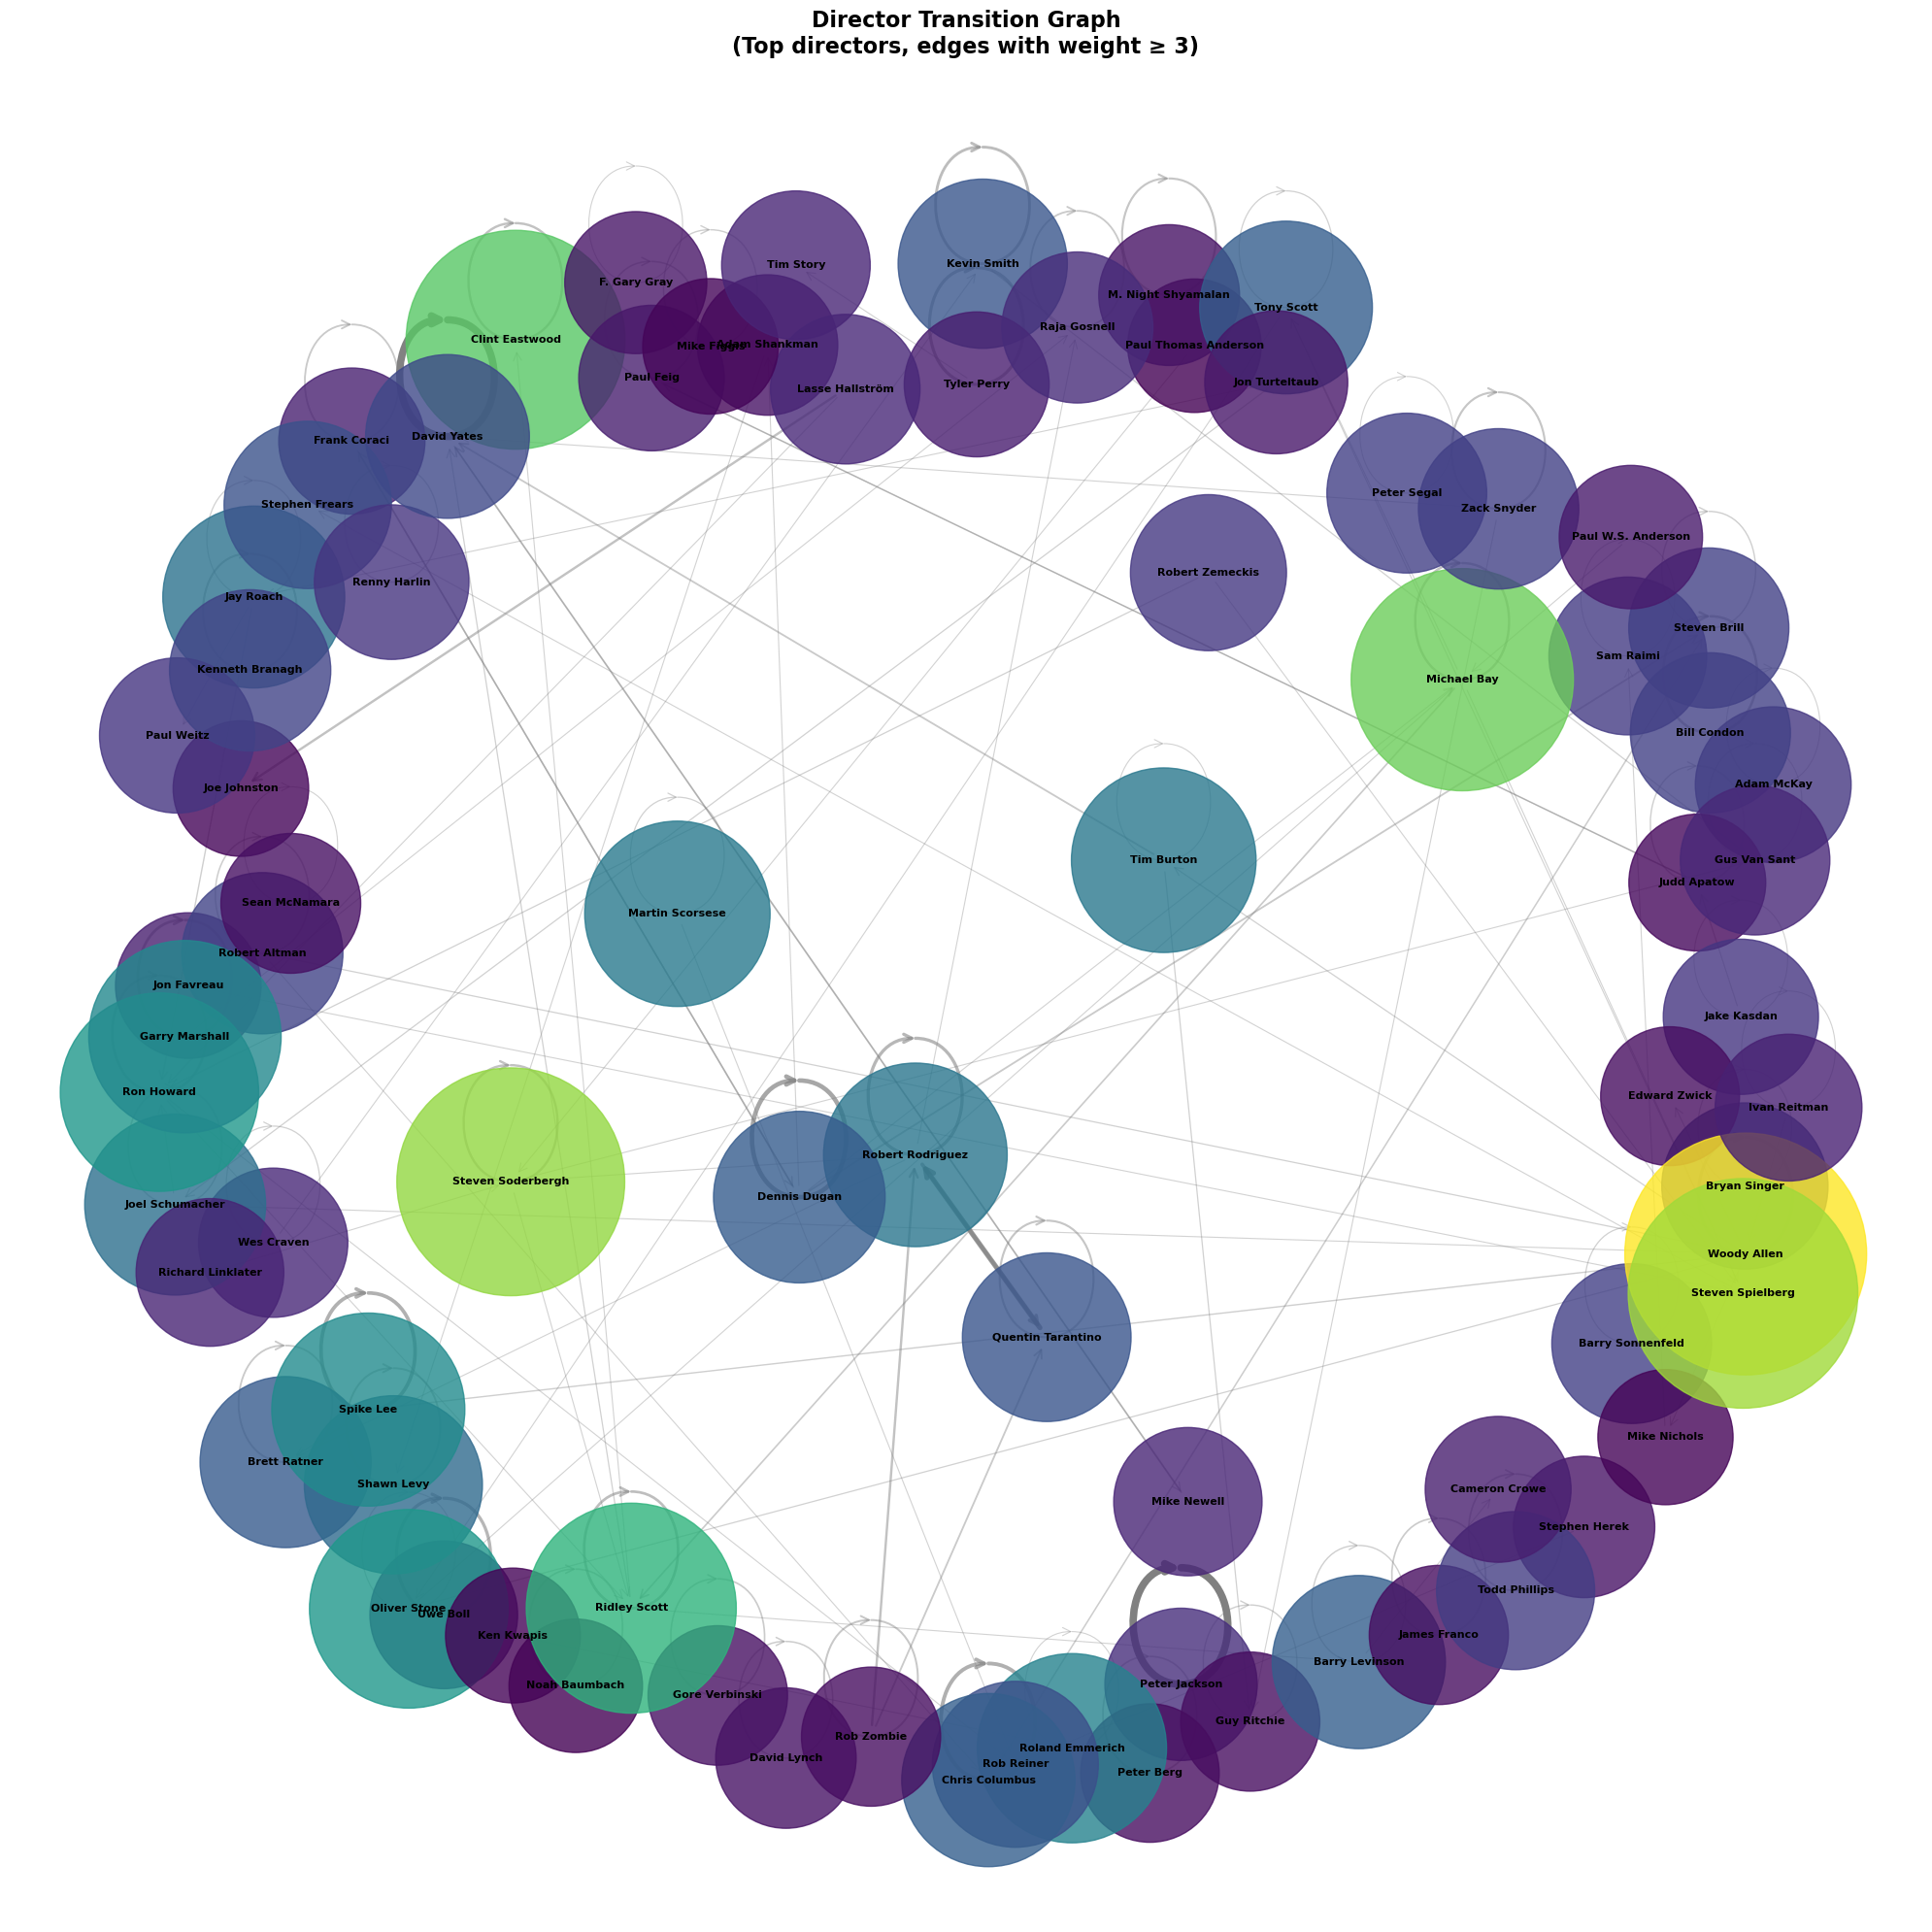


Graph saved as 'director_transition_graph.png'


In [10]:
import matplotlib.pyplot as plt
import networkx as nx

# Filter to most important nodes and edges for visualization
# Keep directors with high degree (connected to many other directors)
degree_dict = dict(director_graph.degree())
sorted_directors = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

# Keep top directors by degree
top_n = 100
top_directors = [d[0] for d in sorted_directors[:top_n]]
subgraph = director_graph.subgraph(top_directors).copy()

# Further filter edges by weight (keep only significant transitions)
edges_to_remove = []
for u, v, data in subgraph.edges(data=True):
    if data['weight'] < 3:  # Only show transitions that happened 3+ times
        edges_to_remove.append((u, v))
subgraph.remove_edges_from(edges_to_remove)

# Remove isolated nodes after edge filtering
isolated = list(nx.isolates(subgraph))
subgraph.remove_nodes_from(isolated)

print(f"Filtered graph for visualization:")
print(f"  Nodes: {subgraph.number_of_nodes()}")
print(f"  Edges: {subgraph.number_of_edges()}")

# Create visualization
fig, ax = plt.subplots(figsize=(20, 20))

# Calculate layout
pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)

# Get edge weights for sizing
edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
max_weight = max(edge_weights) if edge_weights else 1

# Draw edges with width based on weight
for u, v, data in subgraph.edges(data=True):
    weight = data['weight']
    width = 0.5 + (weight / max_weight) * 5  # Scale edge width
    alpha = 0.3 + (weight / max_weight) * 0.7  # Scale transparency
    nx.draw_networkx_edges(subgraph, pos, [(u, v)], 
                           width=width, alpha=alpha,
                           edge_color='gray', arrows=True,
                           arrowsize=15, arrowstyle='->', ax=ax)

# Draw nodes sized by degree
node_sizes = [degree_dict[node] * 50 for node in subgraph.nodes()]
node_colors = [degree_dict[node] for node in subgraph.nodes()]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes,
                       node_color=node_colors, cmap='viridis',
                       alpha=0.8, ax=ax)

# Draw labels
nx.draw_networkx_labels(subgraph, pos, font_size=8, 
                        font_weight='bold', ax=ax)

plt.title("Director Transition Graph\n(Top directors, edges with weight ≥ 3)", 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('director_transition_graph.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGraph saved as 'director_transition_graph.png'")

In [11]:
director_graph.has_node('Steven Spielberg')

True

In [12]:
degree_centrality = nx.degree_centrality(director_graph)
eigen_centrality = nx.eigenvector_centrality(director_graph)

The degrees with high centrality are the popular directors.

In [13]:
sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]

[('Woody Allen', 0.03756718859546623),
 ('Steven Spielberg', 0.033886422061229264),
 ('Steven Soderbergh', 0.03336059827062398),
 ('Michael Bay', 0.03172470203318532),
 ('Clint Eastwood', 0.03078990418322038),
 ('Ridley Scott', 0.028336059827062398),
 ('Oliver Stone', 0.025356391680299135),
 ('Ron Howard', 0.025297966814676328),
 ('Spike Lee', 0.02395419490535172),
 ('Garry Marshall', 0.023778920308483293)]

In [14]:
from Artist_Director_Graph.actor_director_functions import get_popular_directors


#We use the IMDb dataset and get rid of movies before 1990
df_movies_imdb = pd.read_csv('../Datasets/IMDb movies.csv', index_col=0, low_memory=False)
df_movies_imdb = df_movies_imdb[pd.to_numeric(df_movies_imdb['year'], errors='coerce') >= 1990]

# Sort by average popularity
director_popularity = get_popular_directors(df_movies_imdb)


In [15]:
# We find the most popular directors
popularity_threshold = director_popularity['total_popularity'].quantile(0.75)
popular_directors = set(director_popularity[director_popularity['total_popularity'] >= popularity_threshold]['director'])

In [16]:
len(popular_directors)

7256

In [17]:
director_popularity

,director,total_popularity,num_movies
4911,Christopher Nolan,99486881.7,11
21629,Quentin Tarantino,75651625.0,12
25560,Steven Spielberg,64856945.6,20
21042,Peter Jackson,60483109.9,11
6127,David Fincher,56634054.9,10
...,...,...,...
27983,Waleed Bedour,139.2,1
18524,Michele Lunella,138.6,1
12405,Jianrong Zhuo,133.1,1
388,Aeneas Middleton,128.7,1


Find the smallest X such that all top 50 popular directors are included within the top X nodes ranked by centrality.

In [18]:
sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

In [19]:
sorted_nodes

[('Woody Allen', 0.03756718859546623),
 ('Steven Spielberg', 0.033886422061229264),
 ('Steven Soderbergh', 0.03336059827062398),
 ('Michael Bay', 0.03172470203318532),
 ('Clint Eastwood', 0.03078990418322038),
 ('Ridley Scott', 0.028336059827062398),
 ('Oliver Stone', 0.025356391680299135),
 ('Ron Howard', 0.025297966814676328),
 ('Spike Lee', 0.02395419490535172),
 ('Garry Marshall', 0.023778920308483293),
 ('Roland Emmerich', 0.023019397055386772),
 ('Martin Scorsese', 0.02208459920542183),
 ('Tim Burton', 0.021909324608553403),
 ('Robert Rodriguez', 0.021675625146062166),
 ('Jay Roach', 0.0212666510867025),
 ('Joel Schumacher', 0.021032951624211264),
 ('Shawn Levy', 0.020390278102360365),
 ('Christopher Nolan', 0.019806029446132276),
 ('Barry Levinson', 0.019280205655526992),
 ('Chris Columbus', 0.019280205655526992),
 ('Tony Scott', 0.019163355924281374),
 ('J.J. Abrams', 0.018988081327412948),
 ('Dennis Dugan', 0.01892965646179014),
 ('Brett Ratner', 0.018812806730544522),
 ('Kevi

In [20]:
node_to_rank = {node: rank + 1 for rank, (node, _) in enumerate(sorted_nodes)}

In [21]:
node_to_rank

{'Woody Allen': 1,
 'Steven Spielberg': 2,
 'Steven Soderbergh': 3,
 'Michael Bay': 4,
 'Clint Eastwood': 5,
 'Ridley Scott': 6,
 'Oliver Stone': 7,
 'Ron Howard': 8,
 'Spike Lee': 9,
 'Garry Marshall': 10,
 'Roland Emmerich': 11,
 'Martin Scorsese': 12,
 'Tim Burton': 13,
 'Robert Rodriguez': 14,
 'Jay Roach': 15,
 'Joel Schumacher': 16,
 'Shawn Levy': 17,
 'Christopher Nolan': 18,
 'Barry Levinson': 19,
 'Chris Columbus': 20,
 'Tony Scott': 21,
 'J.J. Abrams': 22,
 'Dennis Dugan': 23,
 'Brett Ratner': 24,
 'Kevin Smith': 25,
 'Quentin Tarantino': 26,
 'Stephen Frears': 27,
 'Bryan Singer': 28,
 'Rob Reiner': 29,
 'David Yates': 30,
 'David Fincher': 31,
 'Antoine Fuqua': 32,
 'Kenneth Branagh': 33,
 'Robert Altman': 34,
 'Zack Snyder': 35,
 'Steven Brill': 36,
 'Bill Condon': 37,
 'Barry Sonnenfeld': 38,
 'Peter Segal': 39,
 'Michael Winterbottom': 40,
 'Todd Phillips': 41,
 'Sam Raimi': 42,
 'Robert Zemeckis': 43,
 'Adam McKay': 44,
 'Jake Kasdan': 45,
 'Paul Weitz': 46,
 'Renny Har

In [22]:
from Director_Director_Graph.director_graph_functions import calculate_popular_directors_in_degree_centrality

# Find minimum X for each centrality measure
centrality_measures = {
    'Degree Centrality': degree_centrality,
    'Eigenvector Centrality': eigen_centrality
}

results = {}
for measure_name, centrality_dict in centrality_measures.items():
    print(f"\nAnalyzing {measure_name}...")
    result = calculate_popular_directors_in_degree_centrality(centrality_dict, popular_directors)
    results[measure_name] = result

    print(f"  Minimum X = {result['min_X']}")
    if result['worst_ranked_director']:
        print(f"  Worst ranked popular director: {result['worst_ranked_director'][0]} (rank {result['worst_ranked_director'][1]})")
    if result['directors_not_in_graph']:
        print(f"  Note: {len(result['directors_not_in_graph'])} popular directors not in graph: {', '.join(result['directors_not_in_graph'])}")


Analyzing Degree Centrality...
  Minimum X = 17115
  Worst ranked popular director: Anna Rose Holmer (rank 17115)
  Note: 1309 popular directors not in graph: Yoshitaka Takeuch, Andrew Lau, Blutch, Jude Anthany Joseph, Rakhshan Banietemad, Han-min Kim, Alê Abreu, Naoyuki Tomomatsu, Ahsan Rahim, Young-Tak Kim, Nila Madhab Panda, Michael Haigney, Houda Benyamina, João Pedro Rodrigues, Caner Alper, Prithviraj Sukumaran, Tareque Masud, Shiva Nirvana, Zachary Donohue, Selçuk Aydemir, Viktor Chouchkov, Hyeong-Cheol Kang, Han Han, Baoping Cao, N. Krishna, Grímur Hákonarson, Gippy Grewal, Bogdan Mirica, Luis Ortega, Onur Bilgetay, Siddiq Barmak, Hanung Bramantyo, Jis Joy, Mainak Bhaumik, Benjamín Ávila, Sagar Ballary, Ljubisa Samardzic, Rishab Shetty, Juan Taratuto, Ibrahim El-Batout, Shiboprosad Mukherjee, Harshavardhan Kulkarni, Chandra Sekhar Yeleti, Burhan Qurbani, Jin Jang, Sang-hoon Ahn, Mandeep Kumar, Harish Shankar, Jang-Hoon Lee, Demián Rugna, Drew T. Pierce, Prosit Roy, Michelangelo

In [23]:
results['Degree Centrality']['worst_ranked_director']

('Anna Rose Holmer', 17115, 0.0)

In [24]:
# Calculate eigenvector centrality for comparison with degree centrality
print("Calculating eigenvector centrality...")
eigen_centrality = nx.eigenvector_centrality(director_graph, max_iter=1000)
print("Done!")

Calculating eigenvector centrality...
Done!


In [25]:
len(popular_directors)

7256

In [26]:
popular_directors

{'Cary Murnion',
 'Leigh Janiak',
 'Yoshitaka Takeuch',
 'Scot Armstrong',
 'Roger Michell',
 'Rob Schmidt',
 'Jenny Gage',
 'Michele Mulroney',
 'Mikael Marcimain',
 'Hiroyuki Nakano',
 'Andrew Lau',
 'Marc Lawrence',
 'Omid Nooshin',
 'Marcel Langenegger',
 'Michel Hazanavicius',
 'Cãlin Peter Netzer',
 'Farhan Akhtar',
 'Blutch',
 'Justin Theroux',
 'Danny Perez',
 'Brett Haley',
 'Charlie Stratton',
 'Carter Smith',
 'Masayuki',
 'Ricky Tognazzi',
 'Dante Lam',
 'Daniel Stamm',
 'Paul Feig',
 'Ben Rock',
 'Jude Anthany Joseph',
 'Malcolm Mowbray',
 'Jim Mickle',
 'Romain Gavras',
 'Ron Maxwell',
 'Rakhshan Banietemad',
 'Adam Salky',
 'Mary McGuckian',
 'Jean-Paul Rappeneau',
 'Han-min Kim',
 'Leszek Dawid',
 'Peter Farrelly',
 'Peter Chelsom',
 'James B. Harris',
 'Radhika Rao',
 'Claudio Cupellini',
 'Alê Abreu',
 'Klaus Härö',
 'John Hyams',
 'Jason Lei Howden',
 'Chris Noonan',
 'John Andreas Andersen',
 'Richard E. Grant',
 'Naoyuki Tomomatsu',
 'Ahsan Rahim',
 'Chris Messina'

Analyze how actors transition between working with popular and non-popular directors from the start to the end of their careers.

In [27]:
# Define popularity threshold
# Use directors with above-average popularity as "popular"

In [28]:
# Analyze actor career transitions
# For each actor, find their first and last directors and classify the transition

def get_career_classification(directors_list, popular_directors, n_films=3):
    if len(directors_list) == 0:
        return None, None

    first_films = directors_list[:min(n_films, len(directors_list))]
    last_films = directors_list[-min(n_films, len(directors_list)):]
    
    # Count popular directors in first and last films
    first_popular = sum(1 for d in first_films if d['director'] in popular_directors)
    last_popular = sum(1 for d in last_films if d['director'] in popular_directors)
    
    # Classify based on majority
    start_class = "Popular" if first_popular > len(first_films) / 2 else "Non-Popular"
    end_class = "Popular" if last_popular > len(last_films) / 2 else "Non-Popular"
    
    return start_class, end_class

# Analyze all actors
transitions = {
    ('Non-Popular', 'Non-Popular'): 0,
    ('Non-Popular', 'Popular'): 0,
    ('Popular', 'Non-Popular'): 0,
    ('Popular', 'Popular'): 0
}

actor_min_films = 3  # Only consider actors with at least 3 films

for actor, directors_list in actor_directors_dict.items():
    if len(directors_list) >= actor_min_films:
        start_class, end_class = get_career_classification(directors_list, popular_directors, n_films=3)
        
        if start_class and end_class:
            transitions[(start_class, end_class)] += 1

print(f"Actor Career Transitions (actors with >= {actor_min_films} films):")

total_actors = sum(transitions.values())
for (start, end), count in sorted(transitions.items()):
    percentage = (count / total_actors * 100) if total_actors > 0 else 0
    print(f"{start:15s} → {end:15s}: {count:5d} actors ({percentage:5.1f}%)")

print(f"\nTotal actors analyzed: {total_actors}")

Actor Career Transitions (actors with >= 3 films):
Non-Popular     → Non-Popular    :   792 actors (  9.7%)
Non-Popular     → Popular        :   774 actors (  9.5%)
Popular         → Non-Popular    :  1860 actors ( 22.8%)
Popular         → Popular        :  4746 actors ( 58.1%)

Total actors analyzed: 8172


In [29]:
# Create Sankey diagram showing actor career transitions
import plotly.graph_objects as go

# Define nodes
# 0: Career Start - Non-Popular
# 1: Career Start - Popular  
# 2: Career End - Non-Popular
# 3: Career End - Popular

# Calculate actor counts for each node
career_start_nonpopular = transitions[('Non-Popular', 'Non-Popular')] + transitions[('Non-Popular', 'Popular')]
career_start_popular = transitions[('Popular', 'Non-Popular')] + transitions[('Popular', 'Popular')]
career_end_nonpopular = transitions[('Non-Popular', 'Non-Popular')] + transitions[('Popular', 'Non-Popular')]
career_end_popular = transitions[('Non-Popular', 'Popular')] + transitions[('Popular', 'Popular')]

nodes = [
    f"Career Start:<br>Non-Popular Directors<br>({career_start_nonpopular} actors)",
    f"Career Start:<br>Popular Directors<br>({career_start_popular} actors)",
    f"Career End:<br>Non-Popular Directors<br>({career_end_nonpopular} actors)",
    f"Career End:<br>Popular Directors<br>({career_end_popular} actors)"
]

# Define links (source, target, value)
links = [
    # Non-Popular → Non-Popular
    (0, 2, transitions[('Non-Popular', 'Non-Popular')]),
    # Non-Popular → Popular
    (0, 3, transitions[('Non-Popular', 'Popular')]),
    # Popular → Non-Popular
    (1, 2, transitions[('Popular', 'Non-Popular')]),
    # Popular → Popular
    (1, 3, transitions[('Popular', 'Popular')])
]

# Prepare data for Sankey
source_indices = [link[0] for link in links]
target_indices = [link[1] for link in links]
values = [link[2] for link in links]

# Create colors for the flows
colors = [
    'rgba(200, 200, 200, 0.4)',  # Non-Popular → Non-Popular (gray)
    'rgba(100, 200, 100, 0.6)',  # Non-Popular → Popular (green - upward)
    'rgba(200, 100, 100, 0.6)',  # Popular → Non-Popular (red - downward)
    'rgba(100, 100, 200, 0.6)'   # Popular → Popular (blue - stable)
]

# Node colors
node_colors = [
    'rgba(200, 200, 200, 0.8)',  # Career Start Non-Popular
    'rgba(100, 150, 255, 0.8)',  # Career Start Popular
    'rgba(200, 200, 200, 0.8)',  # Career End Non-Popular
    'rgba(100, 150, 255, 0.8)'   # Career End Popular
]

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=30,
        thickness=30,
        line=dict(color="black", width=1),
        label=nodes,
        color=node_colors,
        x=[0.1, 0.1, 0.9, 0.9],  # Position nodes
        y=[0.8, 0.2, 0.8, 0.2],  # Flipped: Popular at 0.2 (top), Non-Popular at 0.8 (bottom)
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values,
        color=colors,
        label=[f"{v} actors" for v in values]
    )
)])

fig.update_layout(
    title={
        'text': f"Actor Career Transitions: Popular vs Non-Popular Directors<br>" +
                f"<sub>Based on {total_actors} actors with ≥{actor_min_films} films (first 3 vs last 3 films)</sub>",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18, 'color': 'black'}
    },
    font=dict(size=12),
    margin=dict(b=100),
    paper_bgcolor='white',
    height=600,
    width=1000
)

fig.show()

# A bit different config for actually saving the figure to svg, because of font sizes/colors
fig.update_layout(
    title={
        'text': f"Actor Career Transitions: Popular vs Non-Popular Directors<br>" +
                f"<sub>Based on {total_actors} actors with ≥{actor_min_films} films (first 3 vs last 3 films)</sub>",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 24, 'color': 'black'}
    },
    font=dict(size=12, color='black', shadow='auto'),
    font_shadow = "rgba(0, 0, 0, 0)",
    height=300,
    width=500,
    paper_bgcolor='white',  # Set background to white
    plot_bgcolor='white',   # Set plot area to white
    margin=dict(l=20, r=20, t=100, b=100),  # Add margins (left, right, top, bottom)
)
fig.write_image('actor_career_transitions_sankey.svg', width=1000, height=600)

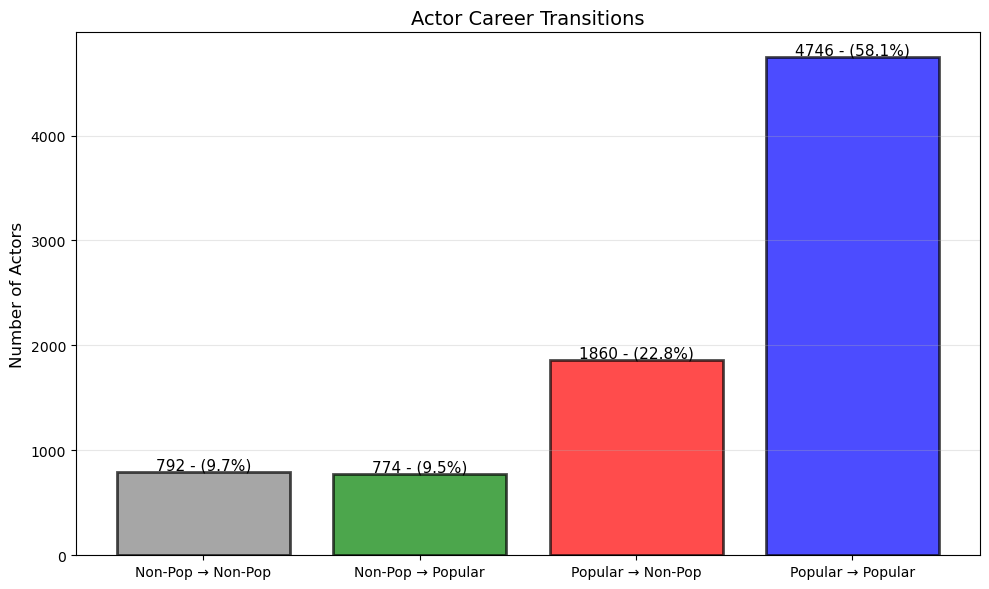

Saved: actor_career_transitions_bars.png


In [30]:
# Create bar chart showing transition patterns
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Prepare data for grouped bar chart
transition_labels = ['Non-Pop → Non-Pop', 'Non-Pop → Popular', 'Popular → Non-Pop', 'Popular → Popular']
transition_counts = [
    transitions[('Non-Popular', 'Non-Popular')],
    transitions[('Non-Popular', 'Popular')],
    transitions[('Popular', 'Non-Popular')],
    transitions[('Popular', 'Popular')]
]
transition_colors = ['gray', 'green', 'red', 'blue']

# Calculate percentages
transition_percentages = [(count / total_actors * 100) for count in transition_counts]

# Create bar chart
bars = ax.bar(transition_labels, transition_counts, color=transition_colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Actors', fontsize=12)
ax.set_title('Actor Career Transitions', fontsize=14)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars (both count and percentage)
for bar, count, percentage in zip(bars, transition_counts, transition_percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)} - ({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=11)

# Rotate x labels for better readability
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('actor_career_transitions_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: actor_career_transitions_bars.png")

In [31]:
# Detailed statistics and insights
print(f"\n{'='*100}")
print("DETAILED ANALYSIS: Actor Career Transitions")
print(f"{'='*100}\n")

# Calculate key metrics
started_nonpopular = transitions[('Non-Popular', 'Non-Popular')] + transitions[('Non-Popular', 'Popular')]
started_popular = transitions[('Popular', 'Non-Popular')] + transitions[('Popular', 'Popular')]

ended_nonpopular = transitions[('Non-Popular', 'Non-Popular')] + transitions[('Popular', 'Non-Popular')]
ended_popular = transitions[('Non-Popular', 'Popular')] + transitions[('Popular', 'Popular')]

upward_mobility = transitions[('Non-Popular', 'Popular')]
downward_mobility = transitions[('Popular', 'Non-Popular')]
stable_popular = transitions[('Popular', 'Popular')]
stable_nonpopular = transitions[('Non-Popular', 'Non-Popular')]

print("CAREER START:")
print(f"  Actors who started with non-popular directors: {started_nonpopular:5d} ({started_nonpopular/total_actors*100:5.1f}%)")
print(f"  Actors who started with popular directors:     {started_popular:5d} ({started_popular/total_actors*100:5.1f}%)")

print("\nCAREER END:")
print(f"  Actors who ended with non-popular directors:   {ended_nonpopular:5d} ({ended_nonpopular/total_actors*100:5.1f}%)")
print(f"  Actors who ended with popular directors:       {ended_popular:5d} ({ended_popular/total_actors*100:5.1f}%)")

print("\nMOBILITY PATTERNS:")
print(f"  Upward mobility (Non-Pop → Popular):           {upward_mobility:5d} ({upward_mobility/total_actors*100:5.1f}%)")
print(f"  Downward mobility (Popular → Non-Pop):         {downward_mobility:5d} ({downward_mobility/total_actors*100:5.1f}%)")
print(f"  Stable at popular level:                       {stable_popular:5d} ({stable_popular/total_actors*100:5.1f}%)")
print(f"  Stable at non-popular level:                   {stable_nonpopular:5d} ({stable_nonpopular/total_actors*100:5.1f}%)")

print("\nCONDITIONAL PROBABILITIES:")
if started_nonpopular > 0:
    prob_move_up = upward_mobility / started_nonpopular * 100
    print(f"  P(end with popular | start with non-popular) = {prob_move_up:.1f}%")

if started_popular > 0:
    prob_move_down = downward_mobility / started_popular * 100
    prob_stay_popular = stable_popular / started_popular * 100
    print(f"  P(end with popular | start with popular)     = {prob_stay_popular:.1f}%")
    print(f"  P(end with non-popular | start with popular) = {prob_move_down:.1f}%")

print("\nKEY INSIGHTS:")
print(f"  • Net upward mobility: {upward_mobility - downward_mobility:+d} actors")
if upward_mobility > downward_mobility:
    print(f"    → More actors moved UP to popular directors than moved DOWN")
elif downward_mobility > upward_mobility:
    print(f"    → More actors moved DOWN from popular directors than moved UP")
else:
    print(f"    → Equal upward and downward mobility")

print(f"\n  • {stable_popular + stable_nonpopular} actors ({(stable_popular + stable_nonpopular)/total_actors*100:.1f}%) stayed at the same level")
print(f"  • {upward_mobility + downward_mobility} actors ({(upward_mobility + downward_mobility)/total_actors*100:.1f}%) changed levels")


DETAILED ANALYSIS: Actor Career Transitions

CAREER START:
  Actors who started with non-popular directors:  1566 ( 19.2%)
  Actors who started with popular directors:      6606 ( 80.8%)

CAREER END:
  Actors who ended with non-popular directors:    2652 ( 32.5%)
  Actors who ended with popular directors:        5520 ( 67.5%)

MOBILITY PATTERNS:
  Upward mobility (Non-Pop → Popular):             774 (  9.5%)
  Downward mobility (Popular → Non-Pop):          1860 ( 22.8%)
  Stable at popular level:                        4746 ( 58.1%)
  Stable at non-popular level:                     792 (  9.7%)

CONDITIONAL PROBABILITIES:
  P(end with popular | start with non-popular) = 49.4%
  P(end with popular | start with popular)     = 71.8%
  P(end with non-popular | start with popular) = 28.2%

KEY INSIGHTS:
  • Net upward mobility: -1086 actors
    → More actors moved DOWN from popular directors than moved UP

  • 5538 actors (67.8%) stayed at the same level
  • 2634 actors (32.2%) changed l

In [32]:
import numpy as np
import networkx as nx
from collections import defaultdict
import pandas as pd

def test_director_network_significance(G, n_simulations=1000):
    """
    Test if edge weights in director-director graph are higher than random expectation

    G: NetworkX DiGraph where nodes are directors and edge weights represent
       number of artists who exhibited with both directors in sequence
    """

    # 1. Extract observed edge weights
    observed_weights = {}
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)
        observed_weights[(u, v)] = weight

    # 2. Calculate basic network statistics
    total_weight = sum(observed_weights.values())
    out_strength = dict(G.out_degree(weight='weight'))  # Weighted out-degree
    in_strength = dict(G.in_degree(weight='weight'))    # Weighted in-degree

    # 3. Generate null model expectations
    print(f"Running {n_simulations} simulations for null model...")

    def configuration_model_simulation():
        """
        Generate random network preserving degree sequence
        Using the configuration model approach
        """
        # Create stubs for rewiring
        out_stubs = []
        in_stubs = []

        for node in G.nodes():
            # Add stubs proportional to weighted degree
            out_count = int(out_strength.get(node, 0))
            in_count = int(in_strength.get(node, 0))

            out_stubs.extend([node] * out_count)
            in_stubs.extend([node] * in_count)

        # Shuffle in-stubs to create random matching
        np.random.shuffle(in_stubs)

        # Count edges in randomized network
        random_edges = defaultdict(int)
        for out_node, in_node in zip(out_stubs, in_stubs):
            if out_node != in_node:  # Avoid self-loops
                random_edges[(out_node, in_node)] += 1

        return random_edges

    # Run simulations
    random_weights_dist = defaultdict(list)

    for _ in range(n_simulations):
        random_edges = configuration_model_simulation()

        # Store weights for each edge
        for edge in observed_weights.keys():
            random_weight = random_edges.get(edge, 0)
            random_weights_dist[edge].append(random_weight)

    # 4. Calculate significance metrics
    results = {}

    for edge, observed_weight in observed_weights.items():
        random_weights = random_weights_dist[edge]

        # Calculate statistics
        expected_weight = np.mean(random_weights)
        std_weight = np.std(random_weights)

        # Ratio (how many times higher than expected)
        if expected_weight > 0:
            ratio = observed_weight / expected_weight
        else:
            ratio = float('inf') if observed_weight > 0 else 1

        # Z-score
        if std_weight > 0:
            z_score = (observed_weight - expected_weight) / std_weight
        else:
            z_score = 0

        # P-value (proportion of random weights >= observed)
        p_value = sum(1 for w in random_weights if w >= observed_weight) / len(random_weights)

        results[edge] = {
            'observed': observed_weight,
            'expected': expected_weight,
            'std': std_weight,
            'ratio': ratio,
            'z_score': z_score,
            'p_value': p_value,
            'significant': p_value < 0.05
        }

    return results

def analyze_top_connections(G, results, top_n=10):
    """
    Analyze and display the most over-represented connections
    """
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame.from_dict(results, orient='index')
    df['edge'] = df.index
    df['from_director'] = df['edge'].apply(lambda x: x[0])
    df['to_director'] = df['edge'].apply(lambda x: x[1])

    # Sort by ratio (times higher than expected)
    df_sorted = df.sort_values('ratio', ascending=False)

    print("\n" + "="*80)
    print(f"TOP {top_n} OVER-REPRESENTED CONNECTIONS (compared to random expectation)")
    print("="*80)

    for idx, row in df_sorted.head(top_n).iterrows():
        print(f"\n{row['from_director']} → {row['to_director']}")
        print(f"  Observed weight: {row['observed']:.0f}")
        print(f"  Expected weight: {row['expected']:.2f} (±{row['std']:.2f})")
        print(f"  Ratio: {row['ratio']:.1f}x higher than expected")
        print(f"  Z-score: {row['z_score']:.2f}")
        print(f"  P-value: {row['p_value']:.4f}")
        if row['p_value'] < 0.001:
            print(f"  Significance: ***")
        elif row['p_value'] < 0.01:
            print(f"  Significance: **")
        elif row['p_value'] < 0.05:
            print(f"  Significance: *")

    return df_sorted

def find_elite_clusters(G, results, significance_threshold=0.01, ratio_threshold=5):
    """
    Identify clusters of directors with significantly higher interconnection
    """
    # Find significantly over-represented edges
    significant_edges = [
        edge for edge, stats in results.items()
        if stats['p_value'] < significance_threshold and stats['ratio'] > ratio_threshold
    ]

    # Create subgraph of significant connections
    H = nx.DiGraph()
    for u, v in significant_edges:
        weight = results[(u, v)]['observed']
        ratio = results[(u, v)]['ratio']
        H.add_edge(u, v, weight=weight, ratio=ratio)

    # Find strongly connected components (potential elite clusters)
    clusters = list(nx.strongly_connected_components(H))

    print("\n" + "="*80)
    print("ELITE CLUSTERS (highly interconnected director groups)")
    print("="*80)

    for i, cluster in enumerate(sorted(clusters, key=len, reverse=True)):
        if len(cluster) > 1:
            print(f"\nCluster {i+1}: {len(cluster)} directors")
            print(f"Members: {', '.join(sorted(cluster))}")

            # Calculate average over-representation within cluster
            cluster_ratios = []
            for u in cluster:
                for v in cluster:
                    if u != v and (u, v) in results:
                        cluster_ratios.append(results[(u, v)]['ratio'])

            if cluster_ratios:
                avg_ratio = np.mean(cluster_ratios)
                print(f"Average over-representation: {avg_ratio:.1f}x")

    return H, clusters

# Example usage
def main(director_graph):
    """
    Main analysis function
    """
    # Run significance test
    results = test_director_network_significance(director_graph, n_simulations=1000)

    # Analyze top connections
    df_results = analyze_top_connections(director_graph, results, top_n=10)

    # Find elite clusters
    elite_network, clusters = find_elite_clusters(director_graph, results)

    # Example: Check specific connection (like MoMA-Guggenheim example)
    if ('Director_A', 'Director_B') in results:
        stats = results[('Director_A', 'Director_B')]
        print(f"\nDirector_A → Director_B flow is {stats['ratio']:.1f}x higher than expected")

    return results, df_results, elite_network

# Run the analysis
# results, df_results, elite_network = main(your_director_graph)

In [33]:
results, df_results, elite_network = main(director_graph)

Running 1000 simulations for null model...

TOP 10 OVER-REPRESENTED CONNECTIONS (compared to random expectation)

Ekachai Uekrongtham → Miles Forster
  Observed weight: 1
  Expected weight: 0.00 (±0.00)
  Ratio: infx higher than expected
  Z-score: 0.00
  P-value: 0.0000
  Significance: ***

Luis Mandoki → Daniel Gruener
  Observed weight: 1
  Expected weight: 0.00 (±0.00)
  Ratio: infx higher than expected
  Z-score: 0.00
  P-value: 0.0000
  Significance: ***

Ash Christian → Eric Nazarian
  Observed weight: 1
  Expected weight: 0.00 (±0.00)
  Ratio: infx higher than expected
  Z-score: 0.00
  P-value: 0.0000
  Significance: ***

Ash Christian → David Guy Levy
  Observed weight: 1
  Expected weight: 0.00 (±0.00)
  Ratio: infx higher than expected
  Z-score: 0.00
  P-value: 0.0000
  Significance: ***

Ash Christian → Victor Mathieu
  Observed weight: 1
  Expected weight: 0.00 (±0.00)
  Ratio: infx higher than expected
  Z-score: 0.00
  P-value: 0.0000
  Significance: ***

Ash Christian

Correlation analysis

total_popularity:
  Pearson r = 0.223 (p = 0.0000)
  Spearman r = 0.416 (p = 0.0000)
  Kendall tau = 0.288 (p = 0.0000)
  → moderate and significant correlation

num_movies:
  Pearson r = 0.090 (p = 0.0000)
  Spearman r = 0.225 (p = 0.0000)
  Kendall tau = 0.172 (p = 0.0000)
  → weak and significant correlation


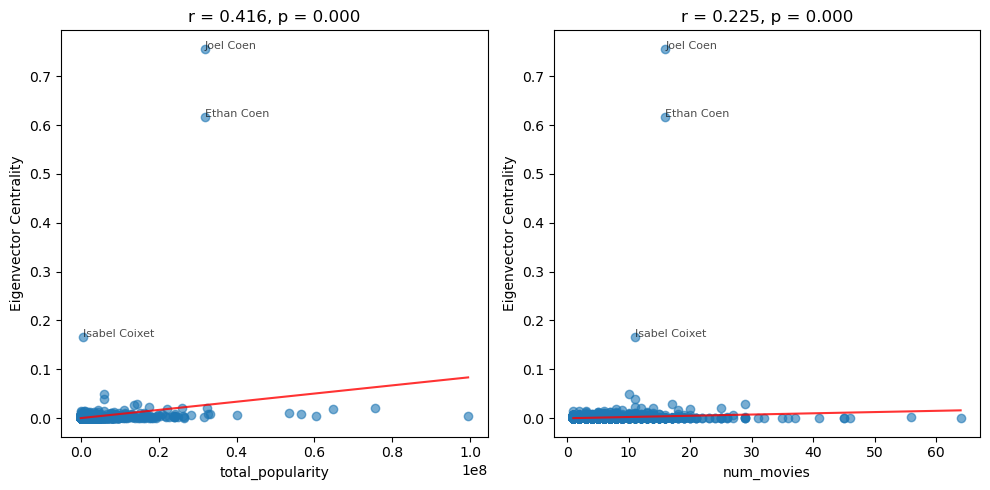

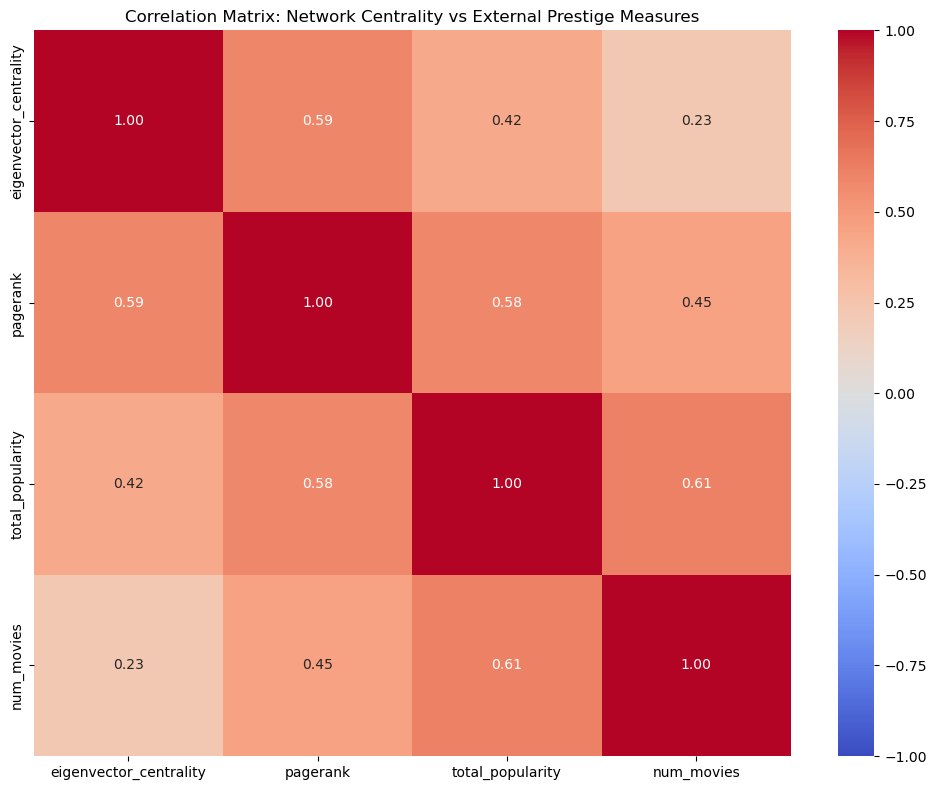

In [34]:
# Run the analysis
from director_graph_functions import analyze_prestige_correlation
results = analyze_prestige_correlation(director_graph, director_popularity)

# The key finding they reported would look like:
# "Eigenvector centrality was strongly correlated with museum rankings (r = 0.82, p < 0.001)"

Correlation summary: Network Metrics vs Director Popularity

EIGENVECTOR CENTRALITY:
  vs total popularity:
    Pearson r  =   0.223 (p = 0.0000)
    Spearman r =   0.416 (p = 0.0000)
    → Moderate correlation ***
  vs popularity rank:
    Pearson r  =  -0.042 (p = 0.0000)
    Spearman r =  -0.416 (p = 0.0000)
    → Moderate correlation ***

PAGERANK:
  vs total popularity:
    Pearson r  =   0.649 (p = 0.0000)
    Spearman r =   0.581 (p = 0.0000)
    → Moderate correlation ***
  vs popularity rank:
    Pearson r  =  -0.411 (p = 0.0000)
    Spearman r =  -0.581 (p = 0.0000)
    → Moderate correlation ***

IN DEGREE:
  vs total popularity:
    Pearson r  =   0.664 (p = 0.0000)
    Spearman r =   0.550 (p = 0.0000)
    → Moderate correlation ***
  vs popularity rank:
    Pearson r  =  -0.388 (p = 0.0000)
    Spearman r =  -0.550 (p = 0.0000)
    → Moderate correlation ***

OUT DEGREE:
  vs total popularity:
    Pearson r  =   0.658 (p = 0.0000)
    Spearman r =   0.551 (p = 0.0000)
   

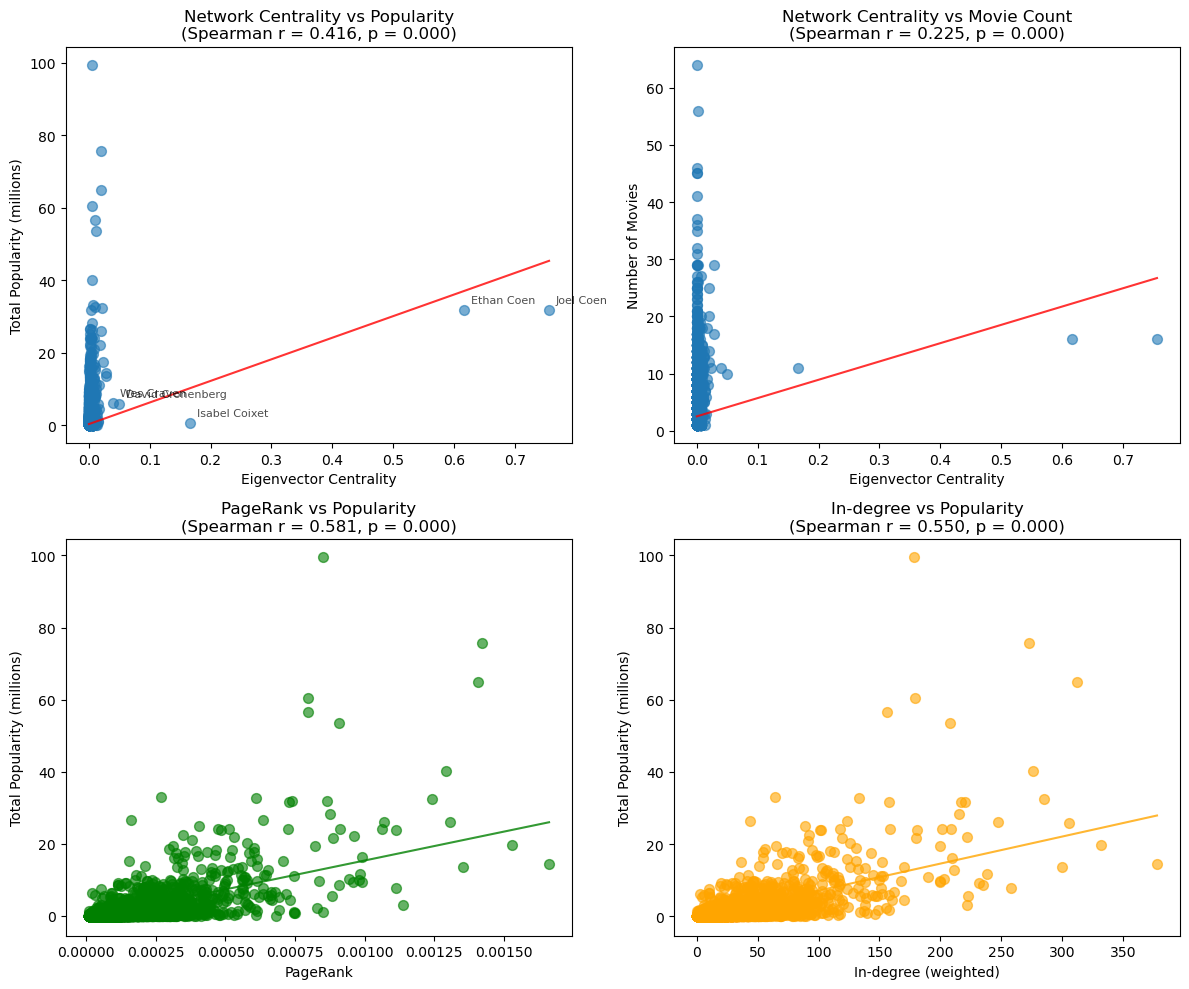

Director ranking comparison: Network Centrality vs Popularity

Rank correlation (Spearman): 0.416 (p=0.0000)
Top-5 overlap: 0.0%
Top-10 overlap: 20.0%
Top-20 overlap: 30.0%
Top 10 directors comparison
Director                       Network Rank    Popularity Rank      Total Popularity    
-------------------------------------------------------------------------------------
Joel Coen                      1               12                             31,810,722
Ethan Coen                     2               11                             31,810,722
Isabel Coixet                  3               1138                              569,534
David Cronenberg               4               203                             5,987,757
Wes Craven                     5               199                             6,049,004
Woody Allen                    6               58                             14,421,317
Robert Rodriguez               7               62                             13,629,570
S

In [35]:
from director_graph_functions import analyze_director_prestige
results, merged_df, comparison = analyze_director_prestige(director_graph, director_popularity)


# Network Distance to Top 10 Directors vs Popularity

Analyze whether the shortest path distance from a director to one of the top 10 most popular directors is linked to their own popularity.

In [36]:
from Director_Director_Graph.director_graph_functions import analyze_distance_to_top_directors

# Run the analysis with DIRECTED distances
results_df, corr, p_value = analyze_distance_to_top_directors(
    director_graph, 
    director_popularity, 
    top_n=10
)

Top 10 most popular directors:
   1. Christopher Nolan (popularity: 99,486,882)
   2. Quentin Tarantino (popularity: 75,651,625)
   3. Steven Spielberg (popularity: 64,856,946)
   4. Peter Jackson (popularity: 60,483,110)
   5. David Fincher (popularity: 56,634,055)
   6. Martin Scorsese (popularity: 53,531,790)
   7. Ridley Scott (popularity: 40,214,401)
   8. Frank Darabont (popularity: 33,075,602)
   9. Robert Zemeckis (popularity: 32,672,930)
  10. Clint Eastwood (popularity: 32,379,841)

Top directors found in graph: 10/10

Calculating shortest path distances...
(Measures: how many career steps to reach a top director)

Reachability from directors to top 10:
  Can reach top 10: 16,510 directors
  Cannot reach top 10: 597 directors (no directed path exists)
Distance to Top 10 vs Popularity

Sample size: 14951 directors (excluding top 10)

Distance to nearest top 10 director vs Total Popularity:
  Pearson r  = -0.1522 (p = 3.5565e-78)
  Spearman r = -0.3384 (p = 0.0000e+00)

=> Stro

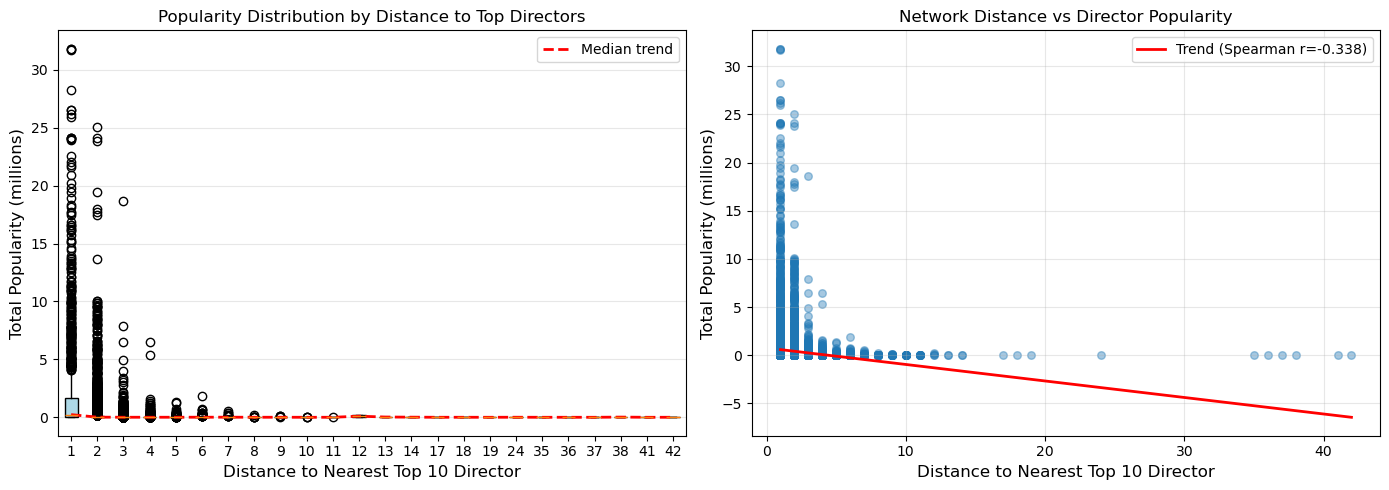


Saved: distance_to_top10_vs_popularity.png


In [37]:
# Visualize the relationship between distance and popularity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Exclude top directors (distance=0) for clearer visualization
analysis_df = results_df[results_df['distance_to_top10'] > 0].copy()

# Plot 1: Boxplot of popularity by distance group
ax1 = axes[0]
distance_values = sorted(analysis_df['distance_to_top10'].unique())
boxplot_data = [analysis_df[analysis_df['distance_to_top10'] == d]['total_popularity'] / 1e6
                for d in distance_values]

bp = ax1.boxplot(boxplot_data, tick_labels=distance_values, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

ax1.set_xlabel('Distance to Nearest Top 10 Director', fontsize=12)
ax1.set_ylabel('Total Popularity (millions)', fontsize=12)
ax1.set_title('Popularity Distribution by Distance to Top Directors', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add median trend line
medians = [analysis_df[analysis_df['distance_to_top10'] == d]['total_popularity'].median() / 1e6
           for d in distance_values]
ax1.plot(range(1, len(distance_values) + 1), medians, 'r--', linewidth=2, label='Median trend')
ax1.legend()

# Plot 2: Scatter plot with trend line
ax2 = axes[1]
ax2.scatter(analysis_df['distance_to_top10'],
           analysis_df['total_popularity'] / 1e6,
           alpha=0.4, s=30)

# Add trend line
z = np.polyfit(analysis_df['distance_to_top10'],
               analysis_df['total_popularity'] / 1e6, 1)
p = np.poly1d(z)
x_line = np.linspace(analysis_df['distance_to_top10'].min(),
                     analysis_df['distance_to_top10'].max(), 100)
ax2.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'Trend (Spearman r={corr:.3f})')

ax2.set_xlabel('Distance to Nearest Top 10 Director', fontsize=12)
ax2.set_ylabel('Total Popularity (millions)', fontsize=12)
ax2.set_title('Network Distance vs Director Popularity', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('distance_to_top10_vs_popularity.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: distance_to_top10_vs_popularity.png")

# Director Transition Probabilities

Define $P[i_{t+1} | i_t]$ as the probability that an actor, currently working with director $i_t$, next makes a film with director $i_{t+1}$.

This is calculated as:
$$P[i_{t+1} | i_t] = \frac{w(i_t \to i_{t+1})}{\sum_{j} w(i_t \to j)}$$

where $w(i_t \to i_{t+1})$ is the number of actors who transitioned from director $i_t$ to director $i_{t+1}$.

In [38]:
from director_graph_functions import compute_transition_probabilities

transition_probs, out_degree_weights = compute_transition_probabilities(director_graph)


In [39]:
top_n = 10

In [40]:
from director_graph_functions import calculate_group_transition_probability
group_results = calculate_group_transition_probability(director_popularity, director_graph, transition_probs, top_n)

print(f"\n{'Popularity Tier':<15} {'N Directors':<15} {'Avg P[top10 | tier]':<20}")
for row in group_results:
    print(f"{row['group']:<15} {row['n_directors']:<15} {row['avg_prob_to_top10']:.6f}")


Popularity Tier N Directors     Avg P[top10 | tier] 
Top 100         91              0.020615
Top 500         396             0.020296
Top 1000        485             0.014047
Top 5000        3405            0.010064
Rest            10970           0.007741


## Network-Constrained Transition Model

**Key Assumption**: An actor working with director $i_t$ can only transition to directors $i_{t+1}$ who have previously worked with actors from director $i_t$. This creates a network effect where reachable directors are determined by past actor movements.

In this model:
- $\mathcal{N}(i_t)$ = set of directors reachable from $i_t$ (neighbors in the graph)
- $P[i_{t+1} | i_t] > 0$ only if $i_{t+1} \in \mathcal{N}(i_t)$

This means directors who are not connected to popular directors through the actor-movement network have **zero probability** of receiving actors from those popular directors, creating potential "gatekeeping" effects.

In [41]:
from director_graph_functions import analyze_network_accessibility
accessibility_results = analyze_network_accessibility(director_graph, director_popularity, top_n)


1. Directors who can receive actors from top 10:
   1,357 directors (7.9% of network)

2. Directors who can send actors to top 10:
   1,293 directors (7.6% of network)

3. Directors with bidirectional access to top 10:
   458 directors (2.7% of network)

4. Directors with no direct connection to top 10:
   14,915 directors (87.1% of network)
Popularity comparison of Accessible vs Non-Accessible Directors

Metric                         Connected to Top 10       Not Connected            
Count                          2,134                     13,213                   
Mean Popularity                1,504,952                 98,950                   
Median Popularity              99,071                    6,335                    
Max Popularity                 31,810,722                24,117,234               

Mann-Whitney U test (accessible > non-accessible):
  U-statistic: 21,481,584
  P-value: 0.0000e+00
  => Highly significant: Directors connected to top 10 are more popular


## Random Walk Model of Actor Careers

Model an actor's career as a **random walk** on the director network:

- At each step $t$, the actor is working with director $i_t$
- The probability of transitioning to director $i_{t+1}$ is:

$$P[i_{t+1} | i_t] = \frac{w(i_t \to i_{t+1})}{\sum_{j \in \mathcal{N}(i_t)} w(i_t \to j)}$$

where $w(i_t \to i_{t+1})$ is the number of actors who previously transitioned from $i_t$ to $i_{t+1}$.

This models career paths as being influenced by historical patterns of actor movement.

In [42]:
from Director_Director_Graph.director_graph_functions import get_transition_probabilities, simulate_many_careers
transition_probs = get_transition_probabilities(director_graph)

print("Simulating 10,000 actor careers (10 steps each)...")
visit_counts, final_positions = simulate_many_careers(director_graph, n_simulations=10000, n_steps=10, transition_probs=transition_probs)

print(f"\nDirectors visited at least once: {len(visit_counts):,}")
print(f"Unique final positions: {len(final_positions):,}")


Simulating 10,000 actor careers (10 steps each)...

Directors visited at least once: 15,389
Unique final positions: 5,271


Random walk results and popularity


Top 20 most visited directors (random walk simulation):
Rank   Director                            Visits     Actual Popularity   
1      Steven Soderbergh                   192                19,772,947
2      Quentin Tarantino                   179                75,651,625
3      Woody Allen                         173                14,421,317
4      Steven Spielberg                    172                64,856,946
5      Clint Eastwood                      154                32,379,841
6      Robert Rodriguez                    151                13,629,570
7      Anthony Russo                       146                24,117,234
8      Michael Bay                         144                25,928,065
9      Zack Snyder                         142                23,811,025
10     Spike Lee                           138                 7,802,419
11     Steven Brill                        138                 3,057,472
12     Ridley Scott                        135                40,

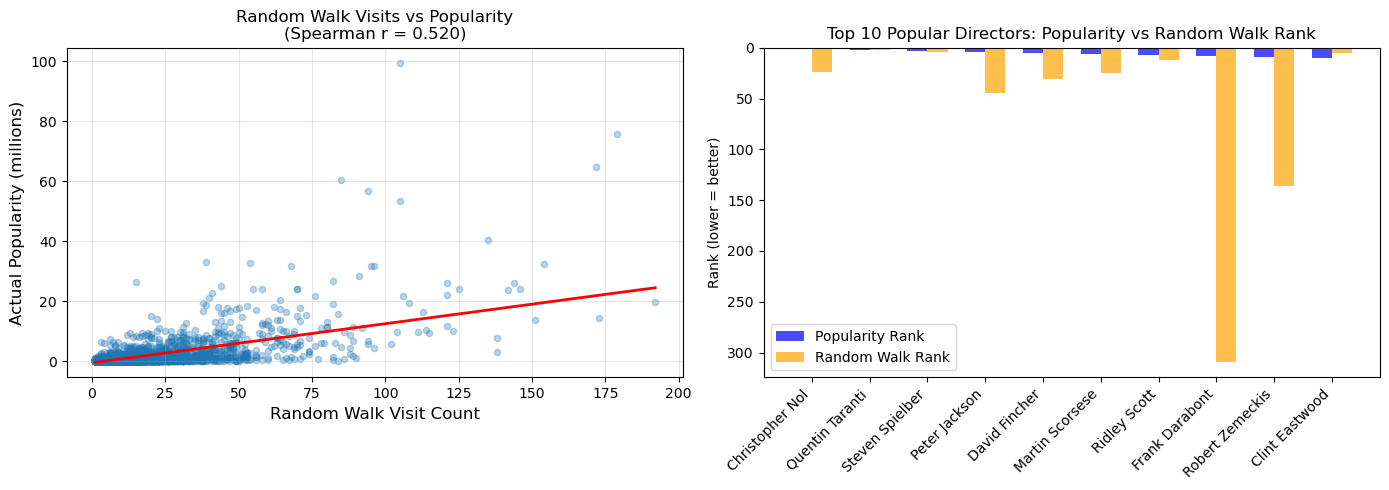


Top-20 overlap: 6/20 directors appear in both random walk and popularity top-20


In [43]:
from Director_Director_Graph.director_graph_functions import top_20_most_visited_directors_and_total_popularity, \
    visualize_top_20_most_visited_directors_and_total_popularity

merged, spearman_r, pearson_r= top_20_most_visited_directors_and_total_popularity(visit_counts, director_popularity )

visualize_top_20_most_visited_directors_and_total_popularity(merged,spearman_r,visit_counts, director_popularity)

## Memory-Based Transition Model (Equation 1)

Extend the random walk model to include a **memory component** that considers the actor's full filmography $(i_1, i_2, \ldots, i_t)$:

$$P[i_{t+1} | i_t, \ldots, i_1] = K \cdot \mu[\pi_{i_{t+1}}; m_\tau] \cdot P[i_{t+1} | i_t] \tag{1}$$

**Memory function:**
$$\mu[\pi_{i_{t+1}}; m_\tau] = \frac{P[\pi_{i_{t+1}} | m_\tau]}{P[\pi_{i_{t+1}}]} \tag{2}$$

**Average reputation:**
$$m_\tau = \frac{1}{\tau} \sum_{k=1}^{n_\tau} \pi_{i_{\tau-k+1}} \tag{3}$$

Where:
- $m_\tau$ = average prestige of the actor's past $n_\tau$ exhibitions/films
- $P[\pi_{i_{t+1}} | m_\tau]$ = probability of next director's prestige given actor's memory
- $P[\pi_{i_{t+1}}]$ = marginal probability of that prestige level
- $K$ = normalization constant

In [44]:
from Director_Director_Graph.director_graph_functions import compute_average_reputation, normalize_prestige, \
    estimate_Pn, mu_memory_function, get_bin, calculate_transitions_with_memory_context, get_P_pi_given_m, estimate_pim
import numpy as np
from collections import Counter, defaultdict

# Create director prestige dictionary (using log-popularity for numerical stability)
director_prestige = {}
for _, row in director_popularity.iterrows():
    director_prestige[row['director']] = np.log1p(row['total_popularity'])

# Get min/max for normalization
prestige_values = list(director_prestige.values())
prestige_min, prestige_max = min(prestige_values), max(prestige_values)

print("Estimate P[π] and P[π|m] from actual actor career data...")

# Discretize prestige into bins for probability estimation
n_bins = 20
prestige_bins = np.linspace(0, 1, n_bins + 1)

# Collect all transitions with memory context from actual data
transitions_data, all_prestiges = calculate_transitions_with_memory_context(actor_directors_dict, director_prestige, prestige_min, prestige_max)


# Estimate P[π] - marginal probability of prestige
P_pi = estimate_Pn(n_bins, all_prestiges, prestige_bins)

# Estimate P[π|m] - conditional probability given memory
# Create 2D histogram: rows = m_tau bins, cols = pi_next bins
joint_counts, m_tau_counts = estimate_pim(n_bins, transitions_data, prestige_bins)

# P[π|m] = joint / P[m]
P_pi_given_m = get_P_pi_given_m(n_bins, m_tau_counts, joint_counts)

print(f"Probability distributions estimated over {n_bins} bins")




Estimate P[π] and P[π|m] from actual actor career data...
Probability distributions estimated over 20 bins


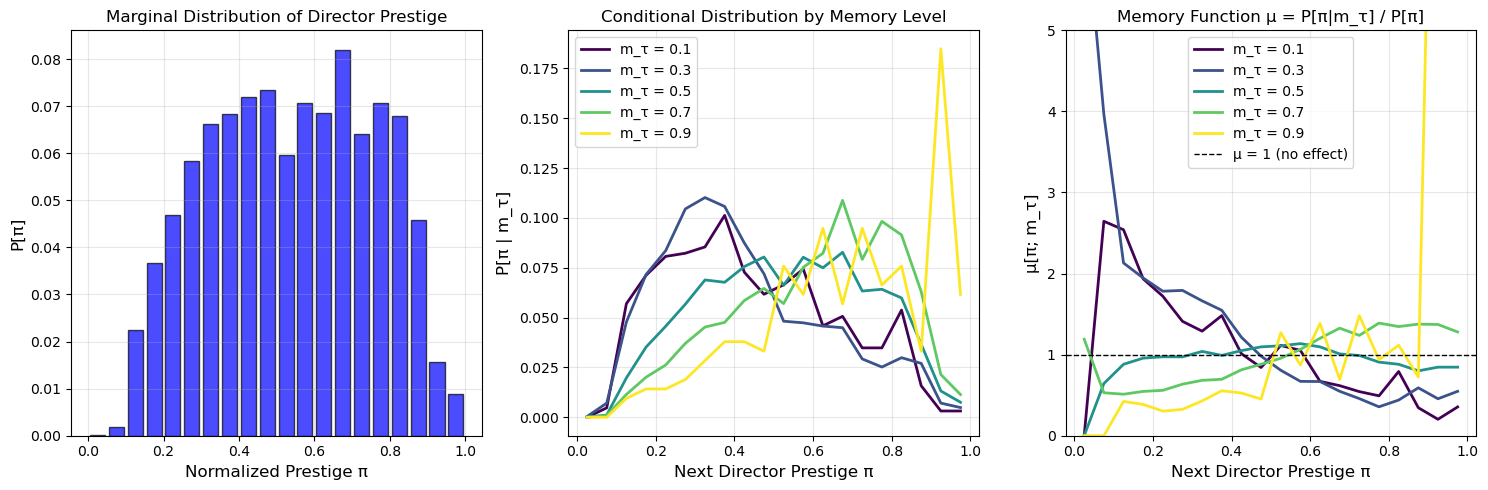


Interpretation:
- μ > 1: Actor with memory m_τ is MORE likely to work with director of prestige π
- μ < 1: Actor with memory m_τ is LESS likely to work with director of prestige π
- μ = 1: No memory effect (same as marginal probability)


In [45]:
from Director_Director_Graph.director_graph_functions import visualize_memory_effect

visualize_memory_effect(prestige_bins,P_pi, P_pi_given_m)

In [46]:
from Director_Director_Graph.director_graph_functions import memory_random_walk_eq1, simulating_careers
import random

# Simulate careers with memory model
print("Simulating 5,000 careers with MEMORY model (Eq. 1, n_τ=5)...")
np.random.seed(42)
random.seed(42)

starting_directors = [d for d in director_graph.nodes() if director_graph.out_degree(d) > 0]
memory_visits, memory_careers = simulating_careers(director_graph, prestige_min, prestige_max,prestige_bins, P_pi_given_m, P_pi,director_prestige,n_steps=10,n_tau=5, transition_probs=transition_probs)

print(f"Simulated {len(memory_careers):,} careers")
print(f"Directors visited: {len(memory_visits):,}")

Simulating 5,000 careers with MEMORY model (Eq. 1, n_τ=5)...
Simulated 5,000 careers
Directors visited: 13,278



Mean prestige at each career step:
Step     Mean Prestige        Std Dev        
-------------------------------------------
0        0.3118              0.1873
1        0.4189              0.2292
2        0.4342              0.2376
3        0.4408              0.2430
4        0.4416              0.2445
5        0.4464              0.2489
6        0.4475              0.2510
7        0.4550              0.2546
8        0.4593              0.2523
9        0.4593              0.2576
10       0.4643              0.2580

Prestige changes for actor's after each movies:
  Mean starting prestige: 0.3118
  Mean ending prestige:   0.4643
  Average change:         +0.1524

Career stability:
  Mean within-career prestige variance: 0.0366
  (Lower = more stable career at consistent prestige level)
Spearman r = 0.4382 (p = 0.0000e+00)


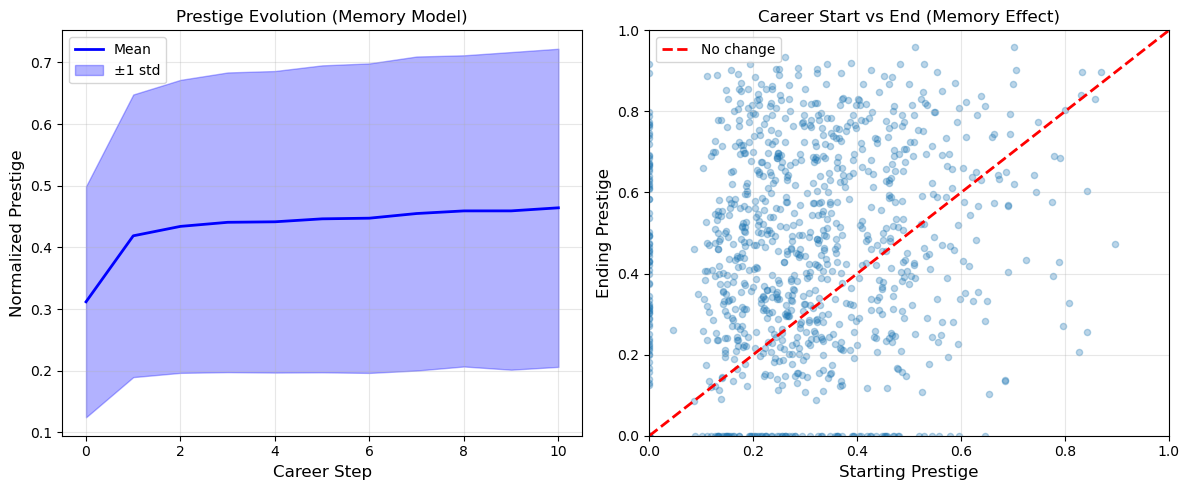

In [52]:
from scipy import stats
from Director_Director_Graph.director_graph_functions import get_prestige_trajectory, pad_trajectory, \
    visualize_prestige_evolution

# Track prestige at each career step
max_len = 11

memory_trajectories = [get_prestige_trajectory(c, director_prestige,  prestige_min, prestige_max) for c in memory_careers]

# Pad shorter careers
memory_padded = np.array([pad_trajectory(t, max_len) for t in memory_trajectories])

# Statistics
mean_prestige = np.mean(memory_padded, axis=0)
std_prestige = np.std(memory_padded, axis=0)

print("\nMean prestige at each career step:")
print(f"{'Step':<8} {'Mean Prestige':<20} {'Std Dev':<15}")
print("-"*43)
for step in range(max_len):
    print(f"{step:<8} {mean_prestige[step]:.4f}              {std_prestige[step]:.4f}")

# Compare starting vs ending prestige
start_prestiges = [t[0] for t in memory_trajectories]
end_prestiges = [t[-1] for t in memory_trajectories if len(t) > 1]

print(f"\nPrestige changes for actor's after each movies:")
print(f"  Mean starting prestige: {np.mean(start_prestiges):.4f}")
print(f"  Mean ending prestige:   {np.mean(end_prestiges):.4f}")
print(f"  Average change:         {np.mean(end_prestiges) - np.mean(start_prestiges):+.4f}")

# Career stability (prestige variance within career)
career_variances = [np.var(t) for t in memory_trajectories if len(t) > 1]
print(f"\nCareer stability:")
print(f"  Mean within-career prestige variance: {np.mean(career_variances):.4f}")
print(f"  (Lower = more stable career at consistent prestige level)")

# Correlation with actual popularity
memory_df = pd.DataFrame(list(memory_visits.items()), columns=['director', 'memory_visits'])
merged = pd.merge(memory_df, director_popularity[['director', 'total_popularity']], on='director')

mem_corr, mem_p = stats.spearmanr(merged['memory_visits'], merged['total_popularity'])

print(f"Spearman r = {mem_corr:.4f} (p = {mem_p:.4e})")


visualize_prestige_evolution(max_len,mean_prestige, std_prestige, start_prestiges, memory_trajectories )

HYPOTHESIS TEST: Reputation → Prestige Transition

H1: Actors with LOW reputation (m≈0.1) have higher chance of moving to LOW-prestige directors
H2: Actors with HIGH reputation (m≈0.9) have higher chance of staying at HIGH-prestige venues
Probability of transitioning to LOW-prestige directors (π < 0.3)
  P[low-prestige | m = 0.1 (low reputation)]  = 0.2959
  P[low-prestige | m = 0.9 (high reputation)] = 0.0569
  P[low-prestige] (marginal)                  = 0.1663

  Ratio: Low-rep actors are 5.20x more likely
         to move to low-prestige directors than high-rep actors
H1 is true: Low-reputation actors more likely to work with low-prestige directors
Probability of transitioning to HIGH-prestige directors (π > 0.7)
  P[high-prestige | m = 0.9 (high reputation)] = 0.5166
  P[high-prestige | m = 0.1 (low reputation)]  = 0.1456
  P[high-prestige] (marginal)                  = 0.2730

  Ratio: High-rep actors are 3.55x more likely
         to work with high-prestige directors than low-r

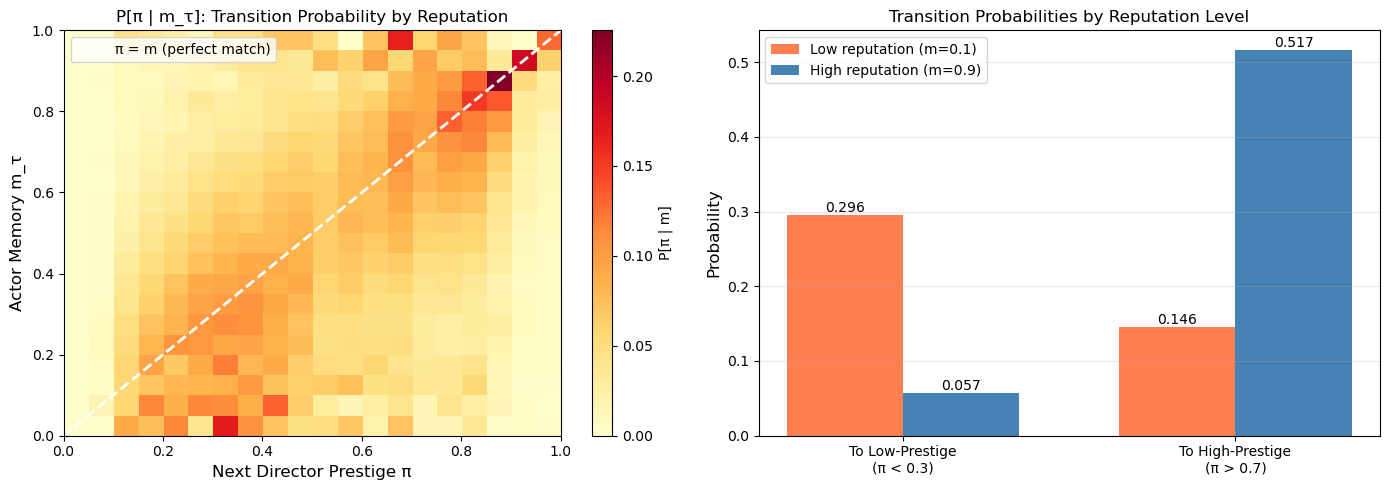

In [53]:
# Test hypothesis: Does reputation determine transition to high/low prestige directors?
print("HYPOTHESIS TEST: Reputation → Prestige Transition")
print("\nH1: Actors with LOW reputation (m≈0.1) have higher chance of moving to LOW-prestige directors")
print("H2: Actors with HIGH reputation (m≈0.9) have higher chance of staying at HIGH-prestige venues")

# Define low/high thresholds
low_prestige_threshold = 0.3   # Bottom 30%
high_prestige_threshold = 0.7  # Top 30%

# Analyze P[π|m] for low and high memory levels
m_low_bin = get_bin(0.1, prestige_bins)
m_high_bin = get_bin(0.9, prestige_bins)

P_pi_given_m_low = P_pi_given_m[m_low_bin, :]
P_pi_given_m_high = P_pi_given_m[m_high_bin, :]

# Calculate cumulative probabilities
bin_centers = (prestige_bins[:-1] + prestige_bins[1:]) / 2

# P[next director is low-prestige | m = low]
low_bins = bin_centers < low_prestige_threshold
P_low_prestige_given_m_low = np.sum(P_pi_given_m_low[low_bins])
P_low_prestige_given_m_high = np.sum(P_pi_given_m_high[low_bins])
P_low_prestige_marginal = np.sum(P_pi[low_bins])

# P[next director is high-prestige | m = high]
high_bins = bin_centers > high_prestige_threshold
P_high_prestige_given_m_high = np.sum(P_pi_given_m_high[high_bins])
P_high_prestige_given_m_low = np.sum(P_pi_given_m_low[high_bins])
P_high_prestige_marginal = np.sum(P_pi[high_bins])


print("Probability of transitioning to LOW-prestige directors (π < {:.1f})".format(low_prestige_threshold))
print(f"  P[low-prestige | m = 0.1 (low reputation)]  = {P_low_prestige_given_m_low:.4f}")
print(f"  P[low-prestige | m = 0.9 (high reputation)] = {P_low_prestige_given_m_high:.4f}")
print(f"  P[low-prestige] (marginal)                  = {P_low_prestige_marginal:.4f}")
print(f"\n  Ratio: Low-rep actors are {P_low_prestige_given_m_low/P_low_prestige_given_m_high:.2f}x more likely")
print(f"         to move to low-prestige directors than high-rep actors")

if P_low_prestige_given_m_low > P_low_prestige_given_m_high:
    print("H1 is true: Low-reputation actors more likely to work with low-prestige directors")
else:
    print("H1 is false")

print("Probability of transitioning to HIGH-prestige directors (π > {:.1f})".format(high_prestige_threshold))
print(f"  P[high-prestige | m = 0.9 (high reputation)] = {P_high_prestige_given_m_high:.4f}")
print(f"  P[high-prestige | m = 0.1 (low reputation)]  = {P_high_prestige_given_m_low:.4f}")
print(f"  P[high-prestige] (marginal)                  = {P_high_prestige_marginal:.4f}")
print(f"\n  Ratio: High-rep actors are {P_high_prestige_given_m_high/P_high_prestige_given_m_low:.2f}x more likely")
print(f"         to work with high-prestige directors than low-rep actors")

if P_high_prestige_given_m_high > P_high_prestige_given_m_low:
    print("H2 is true: High-reputation actors more likely to stay at high-prestige venues")
else:
    print("H2 is false")

# Visualize with heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: P[π|m] heatmap
ax1 = axes[0]
im = ax1.imshow(P_pi_given_m, aspect='auto', origin='lower', cmap='YlOrRd',
                extent=[0, 1, 0, 1])
ax1.set_xlabel('Next Director Prestige π', fontsize=12)
ax1.set_ylabel('Actor Memory m_τ', fontsize=12)
ax1.set_title('P[π | m_τ]: Transition Probability by Reputation', fontsize=12)
plt.colorbar(im, ax=ax1, label='P[π | m]')

# Add diagonal line (perfect matching)
ax1.plot([0, 1], [0, 1], 'w--', linewidth=2, label='π = m (perfect match)')
ax1.legend(loc='upper left')

# Plot 2: Bar chart comparing probabilities
ax2 = axes[1]
x = np.arange(4)
width = 0.35

probs_low_rep = [P_low_prestige_given_m_low, P_high_prestige_given_m_low]
probs_high_rep = [P_low_prestige_given_m_high, P_high_prestige_given_m_high]

bars1 = ax2.bar(x[:2] - width/2, probs_low_rep, width, label='Low reputation (m=0.1)', color='coral')
bars2 = ax2.bar(x[:2] + width/2, probs_high_rep, width, label='High reputation (m=0.9)', color='steelblue')

ax2.set_ylabel('Probability', fontsize=12)
ax2.set_title('Transition Probabilities by Reputation Level', fontsize=12)
ax2.set_xticks(x[:2])
ax2.set_xticklabels(['To Low-Prestige\n(π < 0.3)', 'To High-Prestige\n(π > 0.7)'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
             ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('reputation_prestige_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
